##### Author: Chibueze Ukachi
##### This notebook cleans the data and extracts relevant features 

#### Full code written by author 


#### Network Traffic Data Cleaning based on the output of Mininet Software Defined Networking (SDN) emulation of National Science Foundation (NSF) Topology using the Distributed Internet Traffic Generator to generate the traffic of different application layer protocols 

In [1]:
#load relevant libraries 
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

### Example workflow using Telnet Protocol

In [2]:
telnet_arr = np.loadtxt('Data/dec_recv_Telnet.log.dat')
telnet_arr.shape

(14553, 8)

#### The window size is a hyper paramater chosen by the user. Any window size greater than 3 should work fine. 
#### Note that large windows result in less data for the algorithm to learn from 

In [3]:
#arbitrary window size 
pkt_window_size = 10

In [4]:
#input and output data columns
df_columns = ['Index','Flow','Src_Port','txTime','Dest_Port','Seq','rxTime','Size']
out_cols = ['avg_delay','avg_byte_rate','avg_packet_rate','avg_packet_size','Protocol']

In [5]:
#telnet dataframe 
telnet_df =pd.DataFrame(data = telnet_arr, 
                 columns= df_columns )
telnet_df['Protocol']='Telnet'
mod_telnet_df = pd.DataFrame(columns=out_cols)
telnet_df.head()

,Index,Flow,Src_Port,txTime,Dest_Port,Seq,rxTime,Size,Protocol
0,1.0,2.0,24.0,23.127190,2.0,24.0,23.127246,4.0,Telnet
1,2.0,2.0,24.0,23.128729,2.0,24.0,23.128788,3.0,Telnet
2,3.0,2.0,24.0,23.150484,2.0,24.0,23.150578,1.0,Telnet
3,4.0,2.0,24.0,23.153594,2.0,24.0,23.153682,1.0,Telnet
4,5.0,2.0,24.0,23.159169,2.0,24.0,23.159255,1.0,Telnet


### Feature Extraction 

1. Standardise the dataset to be a multiple of the window size
2. Retrieve the average packet delay 
3. Compute average packet size
4. Compute average byte size
5. Compute average packet rate
6. Combine/concatenate all the features for each application level protocol
7. Use the label encoder to map categorical values to numerical variables
8. Show the distribution of data

###### Please note that the non-uniform data set by running all the protocols for the  duration of 60000ms 
###### On the other hand, the uniform data was gained by running the protocols for different times then reducing the length of the data acquired to the protocol with the least number of samples

### 1. This standardises the length by making each application layer protocol such as Telnet a multiple of the window size

In [6]:
print("Original array: ", telnet_df.shape)
std_quotient = len(telnet_df) - len(telnet_df)%pkt_window_size
len_quotient = int(std_quotient/pkt_window_size)
std_df = telnet_df.iloc[:std_quotient,:]
print("Modified array :", std_df.shape )

Original array:  (14553, 9)
Modified array : (14550, 9)


### 2. The average delay is calculated via the one-way travel time over the window size. This is done by reshaping the array to include a dimension for the window axis then calculating the mean across the new axis 

- W (samples) = window size
- Delay (ms) = Receiver Time - Trasmitter Time 


$$  AverageDelay = \frac{1}{W}{\sum_{i=0}^{W-1}receiverTime_{i}-transmitterTime_{i}}$$


In [7]:
delay_arr = std_df['rxTime'].values - std_df['txTime'].values
avg_delay = np.mean(np.reshape(delay_arr,(len_quotient,pkt_window_size)),1)
mod_telnet_df['avg_delay'] = avg_delay

### 3. The average packet size is calculated as the total number of bytes transmitted in the given window. This is also done by reshaping the array to include a dimension for the window axis then calculating the mean across the new axis 


- W (samples) = window size

$$  AveragePacketSize = \frac{1}{W}{\sum_{i=0}^{W-1}{byteSize_{i}}}$$

***Note that a byte is 8 bits***

In [8]:
byte_arr = std_df['Size'].values
avg_pkt_size_arr = np.mean(np.reshape(byte_arr,(len_quotient,pkt_window_size)),1)

mod_telnet_df['avg_packet_size'] = avg_pkt_size_arr

### 4. The average byte rate is calculated over the total number of bytes received over the window size divided by the duration of the window. 


- W = This is the window size
- Duration = End time - Start time of the receiver window


$$  AverageByteRate = \frac{{\sum_{i=0}^{W-1}{byteSize_{i}}}}{duration}$$

***Please note the weighting function is the duration and not the window size***

In [9]:
total_byte_sum  = np.sum(np.reshape(byte_arr,(len_quotient,pkt_window_size)),1)

rxTime_arr = std_df['rxTime'].values
rxTime_arr_mod = np.reshape(rxTime_arr,(len_quotient,pkt_window_size))
rcv_window_duration = rxTime_arr_mod[:,-1] - rxTime_arr_mod[:,0]

mod_telnet_df['avg_byte_rate'] = total_byte_sum/rcv_window_duration

### 5. The average packet rate is the number of packets  transmitted during the duration of the given window 
$$ AveragePacketRate = \frac{numPacketsPerWindow}{duration}$$

In [10]:
#this is true as there is one packet per sample
num_packets_in_windows = pkt_window_size

mod_telnet_df['avg_packet_rate'] =  num_packets_in_windows/rcv_window_duration
mod_telnet_df['Protocol']='Telnet'

In [11]:
print("The Modifield Telnet dataframe with features extracted:", mod_telnet_df.shape)
mod_telnet_df.head()

The Modifield Telnet dataframe with features extracted: (1455, 5)


,avg_delay,avg_byte_rate,avg_packet_rate,avg_packet_size,Protocol
0,0.000073,373.261494,162.287606,2.3,Telnet
1,0.000028,480.868311,343.477365,1.4,Telnet
2,0.000084,348.108610,105.487458,3.3,Telnet
3,0.000092,775.504747,267.415430,2.9,Telnet
4,0.000112,632.847307,253.138923,2.5,Telnet


### 6. The feature extractor collates all the calculations to retrieve the average delay, byte rate, packet rate and packet size within the specified window into a single function. This is performed for each application layer protocol

In [12]:
non_uniform_files = {
    'Telnet' : np.loadtxt('Data/receiv_log_file_Telnet.dat'),
    'Quake3' : np.loadtxt('Data/receiv_log_file_Quake3.dat'),
    'DNS'    : np.loadtxt('Data/receiv_log_file_DNS.dat'),
    'csa'    : np.loadtxt('Data/receiv_log_file_csa.dat'),
    'csi'    : np.loadtxt('Data/receiv_log_file_csi.dat')
}

In [13]:
uniform_files = {
    'Telnet' : np.loadtxt('Data/dec_recv_Telnet.log.dat'),
    'Quake3' : np.loadtxt('Data/dec_recv_Quake3.log.dat'),
    'DNS'    : np.loadtxt('Data/dec_recv_dns.log.dat'),
    'csa'    : np.loadtxt('Data/dec_recv_csa.log.dat'),
    'csi'    : np.loadtxt('Data/dec_recv_csi.log.dat')
}

In [14]:
def feature_extractor(prot_name,np_arr, window_size, ref_cols,output_cols, balance = None):
    
    """ This returns the extraction of features using the meta data containing just 
        the transmission/receiver times and the individual packet size 
 
        It returns a dataframe containing the average delay,byte_rate, packet_rate, packet_size and protocol 
        
        Note: it is simply a concise summary of 2-5 explained above
    """
    
    inp_df = pd.DataFrame(data = np_arr, columns= ref_cols )   
    inp_df['Protocol'] = prot_name
    inp_df['rxTime'] = 1000* inp_df['rxTime']
    inp_df['txTime'] = 1000* inp_df['txTime']
    
 
    standard_quotient = len(inp_df) - len(inp_df)% window_size    
    length_quotient = int(standard_quotient/window_size)

    standard_df = inp_df.iloc[:standard_quotient,:]
    
    delay_array = standard_df['rxTime'].values - standard_df['txTime'].values
    average_delay = np.mean(np.reshape(delay_array,(length_quotient,window_size)),1)
    #average_delay = np.std(np.reshape(delay_array,(length_quotient,window_size)),1)

    byte_array = standard_df['Size'].values
    avg_pkt_size_array = np.mean(np.reshape(byte_array,(length_quotient,window_size)),1)
    
    total_bytes_sum  = np.sum(np.reshape(byte_array,(length_quotient,window_size)),1)

    rxTime_array = standard_df['rxTime'].values
    rxTime_array_mod = np.reshape(rxTime_array,(length_quotient,window_size))

    recv_window_duration = rxTime_array_mod[:,-1] - rxTime_array_mod[:,0]
    
    output_df = pd.DataFrame(columns=output_cols)
    
    output_df['avg_delay'] = average_delay
    output_df['avg_packet_size'] = avg_pkt_size_array
    output_df['avg_byte_rate'] = total_bytes_sum/recv_window_duration
    output_df['avg_packet_rate'] = window_size/recv_window_duration
    output_df['Protocol']= prot_name  
    
    return output_df    

In [15]:
def df_collator(files, balance = None):
    total_df_arr = []
    for file_name, data_array in files.items():
        prot_df = feature_extractor(file_name, data_array,
                      pkt_window_size,df_columns,out_cols, balance = "Uniform")
        total_df_arr.append(prot_df)

    total_df = pd.concat(total_df_arr, ignore_index=True)
    
    if balance == "Uniform":
        tdf_vals = total_df.Protocol.value_counts()
        min_tdf = np.min(tdf_vals.values)

        total_df = total_df.groupby('Protocol').head(min_tdf)
    
    return total_df
        


In [16]:
total_df_nu = df_collator(non_uniform_files)
total_df_nu['Protocol'].value_counts()

Quake3    8199
Telnet    3340
csa       2606
csi       1422
DNS        100
Name: Protocol, dtype: int64

In [17]:
total_df_u = df_collator(uniform_files, balance = "Uniform")
total_df_u['Protocol'].value_counts()

csi       1455
DNS       1455
Telnet    1455
csa       1455
Quake3    1455
Name: Protocol, dtype: int64

### 7 . The Label Encoder is used to transform categorical variables into numerical variable, which is easier for machine learning computation

In [18]:
le = LabelEncoder()
le.fit(total_df_nu['Protocol'].values)
total_df_nu['NumericalProtocol'] = le.transform(total_df_nu['Protocol'].values)

In [19]:
total_df_nu.head()

,avg_delay,avg_byte_rate,avg_packet_rate,avg_packet_size,Protocol,NumericalProtocol
0,0.0681,0.557483,0.309713,1.8,Telnet,2
1,0.1106,0.315041,0.116682,2.7,Telnet,2
2,0.1086,0.199519,0.110844,1.8,Telnet,2
3,0.0838,0.455778,0.227889,2.0,Telnet,2
4,0.1265,0.500250,0.312656,1.6,Telnet,2


In [20]:
#store the data frame as a csv file
total_df_nu.to_csv("Data/ReadyFeatureExtraction_NonUniform.csv",sep=',')

In [21]:
le = LabelEncoder()
le.fit(total_df_u['Protocol'].values)
total_df_u['NumericalProtocol'] = le.transform(total_df_u['Protocol'].values)

In [22]:
total_df_u.head()

,avg_delay,avg_byte_rate,avg_packet_rate,avg_packet_size,Protocol,NumericalProtocol
0,0.0734,0.373261,0.162288,2.3,Telnet,2
1,0.0283,0.480868,0.343477,1.4,Telnet,2
2,0.0835,0.348109,0.105487,3.3,Telnet,2
3,0.0924,0.775505,0.267415,2.9,Telnet,2
4,0.1122,0.632847,0.253139,2.5,Telnet,2


In [23]:
total_df_u.tail()

,avg_delay,avg_byte_rate,avg_packet_rate,avg_packet_size,Protocol,NumericalProtocol
7889,0.0873,0.711793,0.026363,27.0,csi,4
7890,0.1192,0.717387,0.026375,27.2,csi,4
7891,0.0704,0.751327,0.026549,28.3,csi,4
7892,0.0739,0.724347,0.026436,27.4,csi,4
7893,0.1199,0.731494,0.026313,27.8,csi,4


In [24]:
#store the data frame as a csv file
total_df_u.to_csv("Data/ReadyFeatureExtraction_Uniform.csv",sep=',')

### 8a. This is the histogram plot showing the non-uniformity of the data. It also shows the precise values corresponding to each protocol 

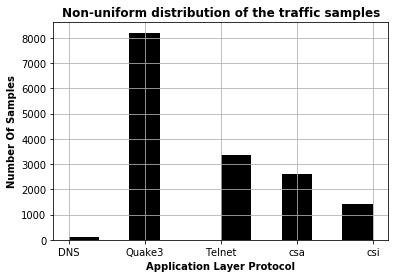

In [25]:
fig1 = plt.figure()
total_df_nu.Protocol.hist(bins=10,color='black')
plt.title("Non-uniform distribution of the traffic samples",fontweight='bold');
plt.xlabel("Application Layer Protocol",fontweight='bold');
plt.ylabel("Number Of Samples",fontweight='bold');
plt.show()

In [26]:
#store the data distribution image as a png file
fig1.savefig('Data/DataDistributionPlot_NonUniform.png')

### 8b. This is the histogram plot showing the uniformity of the data. It also shows the precise values corresponding to each protocol 

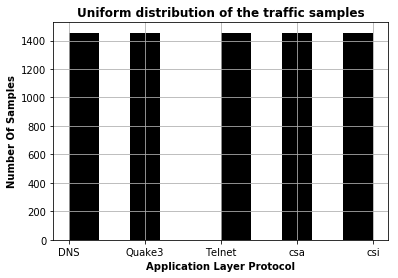

In [27]:
fig2 = plt.figure()
total_df_u.Protocol.hist(bins=10,color='black')
plt.title("Uniform distribution of the traffic samples",fontweight='bold');
plt.xlabel("Application Layer Protocol",fontweight='bold');
plt.ylabel("Number Of Samples",fontweight='bold');
plt.show()

In [28]:
#store the data distribution image as a png file
fig2.savefig('Data/DataDistributionPlot_Uniform.png')